# HES1 Michaelis-Menten toy model

The [HES1 Model](http://pints.readthedocs.io/en/latest/toy/hes1_michaelis_menten_model.html) describes the expression level of the transcription factor Hes1, details of the model see [here](https://doi.org/10.1038/ncomms1496).

The model has 3 state variables $m$, $p_1$ and $p_2$, where $m$ represents the molecular concentrations of Hes1 mRNA, and $p_1, p_2$ represent the molecular concentrations of cytoplasmic and nuclear proteins, respectively.
It is described by the ODE:

\begin{align*}
        \frac{dm}{dt} &= -k_{deg}m + \frac{1}{1 + (p_2/P_0)^h} \\
        \frac{dp_1}{dt} &= -k_{deg} p_1 + \nu m - k_1 p_1 \\
        \frac{dp_2}{dt} &= -k_{deg} p_2 + k_1 p_1
\end{align*}

where $k_1$ is the rate of transport of Hes1 protein into the nucleus; $P_0$ is the amount of Hes1 protein in the nucleus, when the rate of transcription of Hes1 mRNA is at half its maximal value; $\nu$ is the rate of translation of Hes1 mRNA, and $h$ is the Hill coefficient. They are the model parameters to be inferred; whereas $k_{deg}$ is the Hes1 protein degradation rate which is assumed to be known. 

In this model, only the state variable $m$ is an observable, i.e. can be observed in the experiments. The input order of parameters of interest is $\{ P_0, \nu, k_1, h \}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pints
import pints.toy

model = pints.toy.Hes1Model()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 1
Parameters: 4


We can get some suggested parameters and plot some data! In experiments, typically it is not easy to have high sampling rate (time points), so our suggested time points match what is feasible to see in actual experiments. However, it is also good to have a look at what the model does by giving it a higher sampling rate (time points).

[2.4   0.025 0.11  6.9  ]


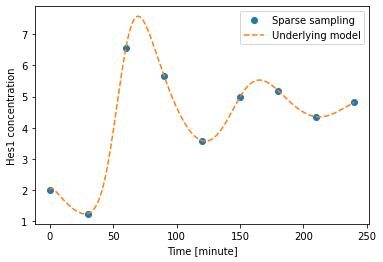

In [2]:
times = model.suggested_times()
smooth_times = np.linspace(times[0], times[-1], 1000)
parameters = model.suggested_parameters()
print(parameters)

plt.figure()
plt.xlabel('Time [minute]')
plt.ylabel('Hes1 concentration')
plt.plot(times, model.simulate(parameters, times), 'o', label='Sparse sampling')
plt.plot(smooth_times, model.simulate(parameters, smooth_times), '--', label='Underlying model')
plt.legend()
plt.show()

In this set-up, we only see one of the state variables representing the Hes1 concentration. However, it is also interesting to see the dynamics of the whole system (i.e. by inspecting all state variables). This can be done by `simulate_all_states(parameters, times)` provided in this model.

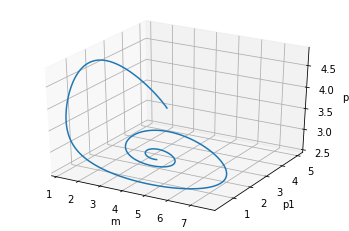

In [3]:
all_states = model.simulate_all_states(parameters, smooth_times)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('m')
ax.set_ylabel('p1')
ax.set_zlabel('p2')
plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2])
plt.show()

We can explore the model further by varying the initial conditions:

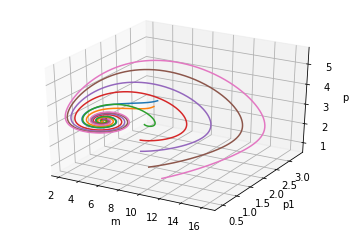

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('m')
ax.set_ylabel('p1')
ax.set_zlabel('p2')

suggested_init = model.initial_conditions()
suggested_hidden_param = np.array(model.implicit_parameters())
for x in [1.5, 1.6, 2, 2.5, 3, 4, 5]:
    model.set_initial_conditions(suggested_init * x)
    model.set_implicit_parameters(list(suggested_hidden_param[0:-1] / x) + [suggested_hidden_param[-1]])
    all_states = model.simulate_all_states(parameters, smooth_times)
    plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2])
plt.show()

# Reset initial conditions
model.set_initial_conditions(suggested_init)
model.set_implicit_parameters(suggested_hidden_param)

Then by varying the parameters:

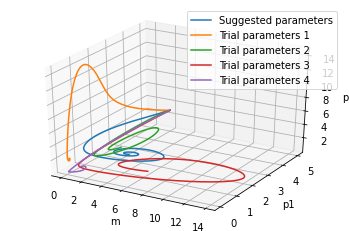

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('m')
ax.set_ylabel('p1')
ax.set_zlabel('p2')

# Try some different parameter sets {P0, v, k1, h}
Try_params = [[0.5, 0.5, 0.6, 4.0],
              [0.5, 0.1, 0.01, 5.5],
              [0.4, 0.01, 0.01, 6.0],
              [0.05, 0.05, 0.01, 7.0]]

# Compare with suggested parameters
all_states = model.simulate_all_states(parameters, smooth_times)
plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2], label='Suggested parameters')
for i, try_param in enumerate(Try_params):
    all_states = model.simulate_all_states(try_param, smooth_times)
    plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2], label='Trial parameters %d'%(i+1))
plt.legend()
plt.show()

We can then try to set up and run a MCMC routine with suggested values which origianlly obtained from real experimental results (taken from [1]):

[1] Silk, D. et al. Designing attractive models via automated identification of chaotic and oscillatory dynamical regimes. Nat. Commun. 2:489 doi: 10.1038/ncomms1496 (2011).

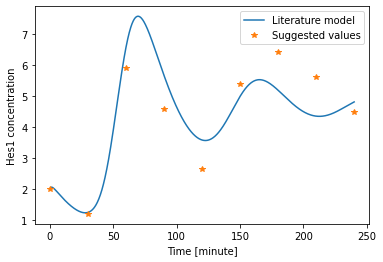

In [6]:
# Get suggested values
values = model.suggested_values()

plt.figure()
plt.xlabel('Time [minute]')
plt.ylabel('Hes1 concentration')
plt.plot(smooth_times, model.simulate(parameters, smooth_times), label='Literature model')
plt.plot(times, values, '*', label='Suggested values')
plt.legend()
plt.show()

In [7]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior(list(parameters * 0.1) + [0.1], 
                                  list(parameters * 10) + [5])
log_likelihood = pints.GaussianLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [list(parameters*1.2) + [0.5]]*3
mcmc = pints.MCMCController(log_posterior, 3, x0)
mcmc.set_max_iterations(10000)
# mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

00  6603   0.183     0.187     0.189      0:17.9
2220  6663   0.183     0.19      0.19       0:18.1
2240  6723   0.183     0.191     0.191      0:18.4
2260  6783   0.184     0.192     0.191      0:18.6
2280  6843   0.184     0.191     0.19       0:18.7
2300  6903   0.185     0.191     0.189      0:19.0
2320  6963   0.185     0.192     0.188      0:19.2
2340  7023   0.187     0.192     0.187      0:19.5
2360  7083   0.189     0.193562  0.188      0:19.8
2380  7143   0.188     0.194     0.188      0:20.1
2400  7203   0.191     0.197     0.187      0:20.3
2420  7263   0.192     0.196     0.187      0:20.6
2440  7323   0.192544  0.195     0.186399   0:20.9
2460  7383   0.196     0.195     0.187      0:21.2
2480  7443   0.198     0.195     0.186      0:21.4
2500  7503   0.198     0.194     0.185      0:21.7
2520  7563   0.198334  0.194764  0.184      0:21.9
2540  7623   0.197     0.195     0.184      0:22.1
2560  7683   0.196     0.195     0.185      0:22.4
2580  7743   0.196     0.195     

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
P_0      3.44    0.82    2.01    3.00   3.63   3.84   4.38     1.10    53.27   0.34
nu       0.03    0.01    0.02    0.02   0.03   0.03   0.04     1.03    420.16  2.68
k_1      0.64    0.22    0.12    0.57   0.66   0.76   1.05     1.08    72.99   0.47
h        33.90   21.35   4.90    9.02   40.39  51.95  66.96    1.52    14.27   0.09
sigma    0.94    0.39    0.40    0.65   0.87   1.15   1.90     1.17    38.02   0.24


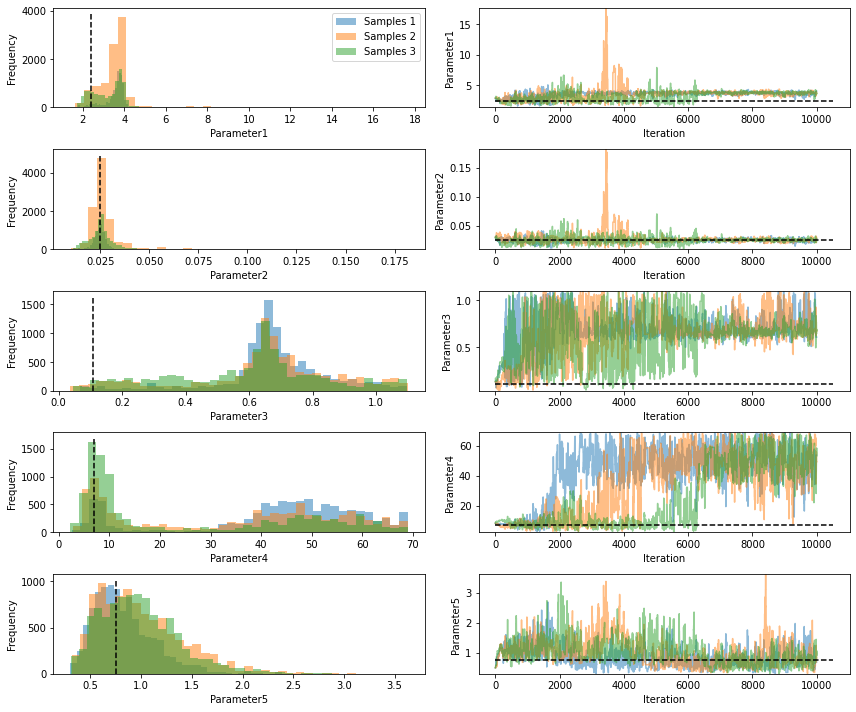

In [8]:
# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['P_0', 'nu', 'k_1', 'h', 'sigma'])
print(results)

import pints.plot
pints.plot.trace(chains, ref_parameters=list(parameters)+[0.75])
plt.show()

We can also compare the predictions with these values to what we found:

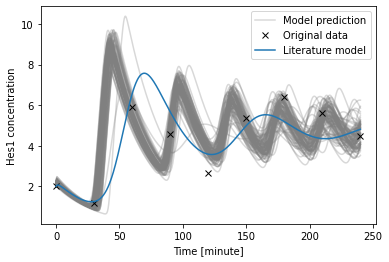

In [9]:
# Select first chain
chain1 = chains[0]

# Remove burn-in
chain1 = chain1[7500:]

# Plot some predictions with these samples
plt.figure()
plt.xlabel('Time [minute]')
plt.ylabel('Hes1 concentration')
for posterior_param in chain1[::25]:
    model_prediction = model.simulate(posterior_param[:-1], smooth_times)
    plt.plot(smooth_times, model_prediction, c='Gray', alpha=0.3)
plt.plot(smooth_times, model_prediction, c='Gray', alpha=0.3, label='Model prediction')
plt.plot(times, values, 'kx', label='Original data')
plt.plot(smooth_times, model.simulate(parameters, smooth_times), label='Literature model')
plt.legend()
plt.show()

This is interesting, as this shows that with the sparse sampling points, we cannot retreive the same dynamical behaviour as the literature model. As it is obvious that (can be seen by eyes!) our model predictions from the MCMC posterior give a closer alignment (hence smaller 'error') to the data points. This could be due to several factors, one of which could be the uninformative prior that we used, and that failed to constraint the parameters in a good biologically/physically justifiable parameter region. One of the tricks to handle such highly non-linear dynamical system with sparse sampling points is used in their original paper [1], which constraints the model to behave or produce the desired dynamics.